In [ ]:
!pip install zarr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 75.6 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5033 sha256=6b8916ac3411848064f6d560e22e463c79f339cb42acf70b520edfeb9cf8ff9a
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

import zarr

## Load and Save Xenium Output Data

Load the masks found by 10x genomics and prep the images and masks to be in the form of the image that will be transformed-> that way we can apply the transformation matrix to the segmentation masks

In [ ]:
# unzip Xeniumum output data
!unzip "drive/MyDrive/spatial-transcriptomics/Xenium/xenium_out.zip"

Archive:  drive/MyDrive/spatial-transcriptomics/Xenium/xenium_out.zip
   creating: outs/
  inflating: outs/experiment.xenium  
   creating: outs/cell_feature_matrix/
  inflating: outs/cell_feature_matrix/barcodes.tsv.gz  
  inflating: outs/cell_feature_matrix/features.tsv.gz  
  inflating: outs/cell_feature_matrix/matrix.mtx.gz  
  inflating: outs/cell_feature_matrix.h5  
 extracting: outs/cell_feature_matrix.zarr.zip  
 extracting: outs/analysis.zarr.zip  
   creating: outs/analysis/
   creating: outs/analysis/clustering/
   creating: outs/analysis/clustering/gene_expression_graphclust/
  inflating: outs/analysis/clustering/gene_expression_graphclust/clusters.csv  
   creating: outs/analysis/clustering/gene_expression_kmeans_10_clusters/
  inflating: outs/analysis/clustering/gene_expression_kmeans_10_clusters/clusters.csv  
   creating: outs/analysis/clustering/gene_expression_kmeans_2_clusters/
  inflating: outs/analysis/clustering/gene_expression_kmeans_2_clusters/clusters.csv  
   

In [ ]:
!unzip "outs/cells.zarr.zip"

Archive:  outs/cells.zarr.zip
 extracting: .zgroup                 
 extracting: .zattrs                 
 extracting: polygon_num_vertices/.zarray  
 extracting: polygon_num_vertices/0.0  
 extracting: polygon_num_vertices/0.1  
 extracting: polygon_num_vertices/1.0  
 extracting: polygon_num_vertices/1.1  
 extracting: polygon_vertices/.zarray  
 extracting: polygon_vertices/0.0.0  
 extracting: polygon_vertices/0.0.1  
 extracting: polygon_vertices/0.0.2  
 extracting: polygon_vertices/0.0.3  
 extracting: polygon_vertices/0.1.0  
 extracting: polygon_vertices/0.1.1  
 extracting: polygon_vertices/0.1.2  
 extracting: polygon_vertices/0.1.3  
 extracting: polygon_vertices/0.2.0  
 extracting: polygon_vertices/0.2.1  
 extracting: polygon_vertices/0.2.2  
 extracting: polygon_vertices/0.2.3  
 extracting: polygon_vertices/0.3.0  
 extracting: polygon_vertices/0.3.1  
 extracting: polygon_vertices/0.3.2  
 extracting: polygon_vertices/0.3.3  
 extracting: polygon_vertices/0.4.0  
 ext

In [ ]:
# Import Python libraries
import zarr
import numpy as np

# Function to open a Zarr file
def open_zarr(path: str) -> zarr.Group:
    store = (zarr.ZipStore(path, mode="r")
    if path.endswith(".zip")
    else zarr.DirectoryStore(path)
    )
    return zarr.group(store=store)

# For example, use the above function to open the cells Zarr file, which contains segmentation mask Zarr arrays
root = open_zarr("outs/cells.zarr.zip")

# Create cell and nucleus segmentation mask np array objects to read or modify
cellseg_mask = np.array(root["masks"][1])
nucseg_mask = np.array(root["masks"][0])

print(f'Shape of CellSeg Mask : {cellseg_mask.shape}')
print(f'Shape of NucSeg Mask: {nucseg_mask.shape}')

Shape of CellSeg Mask : (25778, 35416)
Shape of NucSeg Mask: (25778, 35416)


## Current Visualizations
Visualize Current Cell Segmentation and Nucleus Segmentation Masks

Text(0.5, 1.0, 'Nucleus Segmentation')

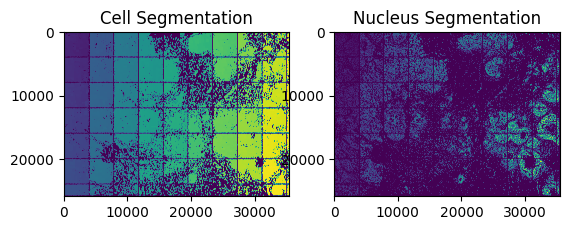

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(cellseg_mask)
plt.title("Cell Segmentation")

plt.subplot(1, 2, 2)
plt.imshow(nucseg_mask)
plt.title("Nucleus Segmentation")


## Cell Segmentation
Apply cellcutter to the Xenium image for Cell Segmentation

In [ ]:
# install Dependencies
!pip install pymaxflow
!git clone https://github.com/jiyuuchc/cellcutter.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.4/798.4 kB 7.2 MB/s eta 0:00:00
Cloning into 'cellcutter'...
remote: Enumerating objects: 621, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 621 (delta 3), reused 0 (delta 0), pack-reused 615
Receiving objects: 100% (621/621), 60.60 MiB | 33.22 MiB/s, done.
Resolving deltas: 100% (387/387), done.


In [ ]:
# load xenium images for segmentation
xenium_im = cv.imread('drive/MyDrive/spatial-transcriptomics/Xenium/he_image.ome.tif')
xenium_im = cv.cvtColor(xenium_im, cv.COLOR_BGR2GRAY)

In [ ]:
# crop the image for training
def training_crop(im, x, y):
  return im[y[0]:y[1], x[0]: x[1]]

In [ ]:
# here we will compute out own markers
def markers(nucx_centers, nucy_centers, crop_x, crop_y, t_form):
  '''
  Return a nx2 matrix where n is the number of cell nuclei in the image.
  The matrix holds the center of mass of each nucelus given from the mask

  The nucleus have already been segmented by 10x genomics

  nucx_centers: the GIVEN nucleus x-centers from the dataset
  nucy_centers: the GIVEN nucleus y-center form the dataset

  Both inputs are in cell (micron) space

  crop_x: 1x2 array, the crop indices in the x direction
  crop_y: 1x2 array, the crop indices in the y direction

  t_form : homogeneous transform matrix from dataset
  '''

  # transform the markers from real space to image space
  nucx = nucx_centers * t_form[1, 1]
  nucy= nucy_centers * t_form[0, 0]

  x_indices = np.nonzero((nucx>=crop_x[0]) & (nucx < crop_x[1]))[0]
  y_indices = np.nonzero((nucy>=crop_y[0]) & (nucy < crop_y[1]))[0]

  indices = np.intersect1d(x_indices, y_indices)

  nucx = nucx[indices]
  nucy = nucy[indices]

  # map centers to current image space
  normalized_nucx = nucx-crop_x[0]
  normalized_nucy = nucy-crop_y[0]

  return normalized_nucx, normalized_nucy

In [ ]:
nuc_x = np.array(root["cell_summary"][:, 3])
nuc_y = np.array(root["cell_summary"][:, 4])
homogeneous_transform = np.array(root['masks/homogeneous_transform'])
normalized_nucx, normalized_nucy = markers(nuc_x, nuc_y, [2000, 3000], [20000, 21000], homogeneous_transform)

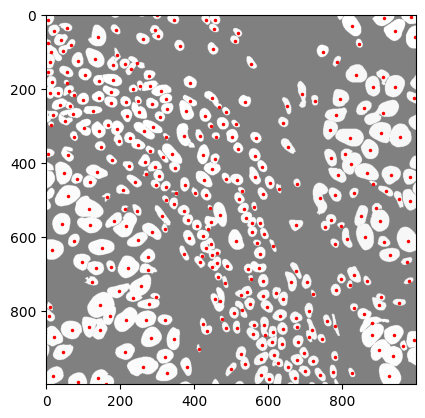

In [ ]:
plt.plot(normalized_nucx, normalized_nucy, '.', markersize = 3, color = 'r')
plt.imshow(nucseg_mask[20000:21000, 2000:3000], cmap = 'gray', alpha = 0.5)

plt.show()

In [ ]:
import sys
sys.path.append('cellcutter')

import time
from os.path import join

import numpy as np
from numpy.random import default_rng
np.set_printoptions(precision=4)

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['image.cmap'] = 'gray'

import cellcutter
import cellcutter.utils

(-0.5, 999.5, 999.5, -0.5)

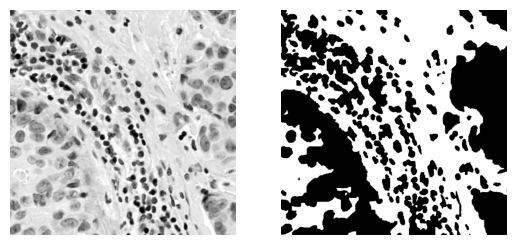

In [ ]:
cropped_im = xenium_im[20000:21000, 2000:3000]
mask = cellcutter.utils.graph_cut(cropped_im, prior = 0.15, max_weight=5, sigma = 0.04)

#check results
fig, ax = plt.subplots(1,2)
ax[0].imshow(cropped_im)
ax[0].axis('off')
ax[1].imshow(mask)
ax[1].axis('off')

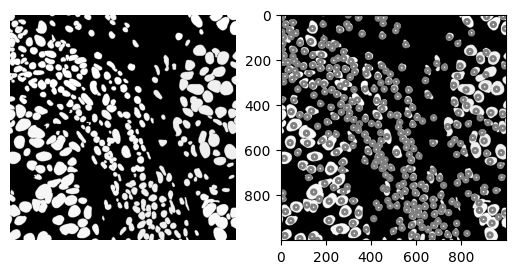

In [ ]:
nucleus_img = nucseg_mask[20000:21000, 2000:3000]

fig, ax = plt.subplots(1,2)
ax[0].imshow(nucleus_img)
ax[0].axis('off')
ax[1].imshow(nucleus_img)
i = 0
for x, y in zip(normalized_nucx, normalized_nucy):
  c = plt.Circle((x, y), 10, color='gray', linewidth=2, fill=False)
  ax[1].add_patch(c)

(355, 2)
(1000, 1000)


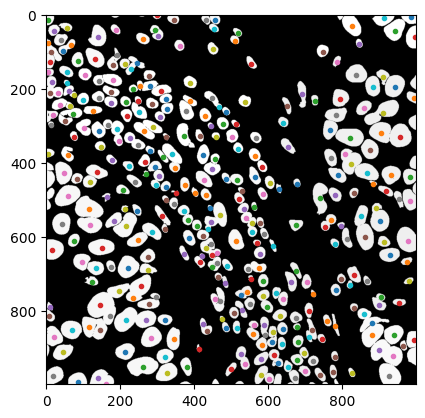

In [ ]:
# put markers in form of Nx2 with y, x convention
y = normalized_nucy[:, np.newaxis]
x = normalized_nucx[:, np.newaxis]
markers = np.concatenate((y, x), axis = 1)

print(markers.shape)

for y,x in markers:
  d = plt.plot(x, y, '.')

plt.imshow(nucleus_img)


print(cropped_im.shape)

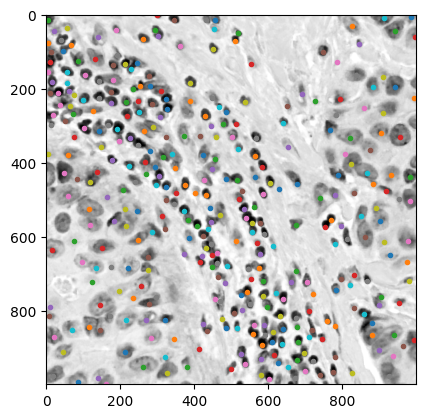

In [ ]:
# put markers in form of Nx2 with y, x convention
y = normalized_nucy[:, np.newaxis]
x = normalized_nucx[:, np.newaxis]
markers = np.concatenate((y, x), axis = 1)

for y,x in markers:
  d = plt.plot(x, y, '.')

plt.imshow(cropped_im)

In [ ]:
dataset = cellcutter.Dataset(cropped_im, markers, mask_img = mask)

start = time.time()
model = cellcutter.UNet4(bn=True)
cellcutter.train_self_supervised(dataset, model, area_size = 640, lam = 1.3, n_epochs = 60)

print('Elapsed time: %f'%(time.time() - start))

Epoch: 1 (32 steps) -- loss: 7877.936523
Epoch: 2 (64 steps) -- loss: 2960.191650
Epoch: 3 (96 steps) -- loss: 1129.640381
Epoch: 4 (128 steps) -- loss: 299.217255
Epoch: 5 (160 steps) -- loss: -58.892433
Epoch: 6 (192 steps) -- loss: -315.794556
Epoch: 7 (224 steps) -- loss: -446.259613
Epoch: 8 (256 steps) -- loss: -561.850098
Epoch: 9 (288 steps) -- loss: -579.763855
Epoch: 10 (320 steps) -- loss: -634.794983
Epoch: 11 (352 steps) -- loss: -688.511841
Epoch: 12 (384 steps) -- loss: -718.496521
Epoch: 13 (416 steps) -- loss: -744.499756
Epoch: 14 (448 steps) -- loss: -767.028809
Epoch: 15 (480 steps) -- loss: -780.089966
Epoch: 16 (512 steps) -- loss: -792.874817
Epoch: 17 (544 steps) -- loss: -815.943359
Epoch: 18 (576 steps) -- loss: -827.110107
Epoch: 19 (608 steps) -- loss: -847.662903
Epoch: 20 (640 steps) -- loss: -838.658386
Epoch: 21 (672 steps) -- loss: -851.716736
Epoch: 22 (704 steps) -- loss: -853.979309
Epoch: 23 (736 steps) -- loss: -842.401062
Epoch: 24 (768 steps) -- 

(-0.5, 999.5, 999.5, -0.5)

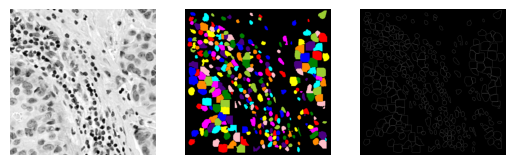

In [ ]:
from skimage.color import label2rgb

label = cellcutter.utils.draw_label(dataset, model, np.zeros_like(cropped_im, dtype=int))
rgb = label2rgb(label, bg_label = 0)
border = cellcutter.utils.draw_border(dataset, model, np.zeros_like(cropped_im, dtype=int))
fig, ax = plt.subplots(1,3)
ax[0].imshow(cropped_im)
ax[0].axis('off')
ax[1].imshow(rgb)
ax[1].axis('off')
ax[2].imshow(border)
ax[2].axis('off')

## Perform Cell Segmentation on a Different Crop

In [ ]:
nuc_x = np.array(root["cell_summary"][:, 3])
nuc_y = np.array(root["cell_summary"][:, 4])
homogeneous_transform = np.array(root['masks/homogeneous_transform'])
normalized_nucx, normalized_nucy = markers(nuc_x, nuc_y, [5000, 6000], [15000, 16000], homogeneous_transform)

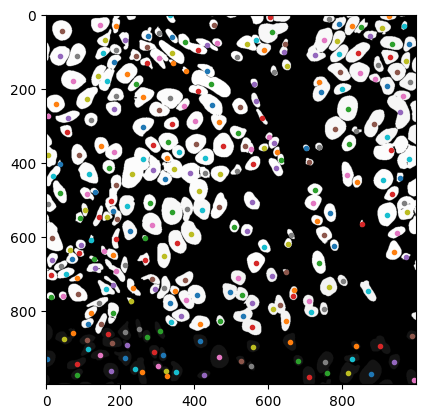

In [ ]:
# put markers in form of Nx2 with y, x convention
y = normalized_nucy[:, np.newaxis]
x = normalized_nucx[:, np.newaxis]
markers = np.concatenate((y, x), axis = 1)

nucleus_img = nucseg_mask[15000:16000, 5000:6000]

for y,x in markers:
  d = plt.plot(x, y, '.')

plt.imshow(nucleus_img)

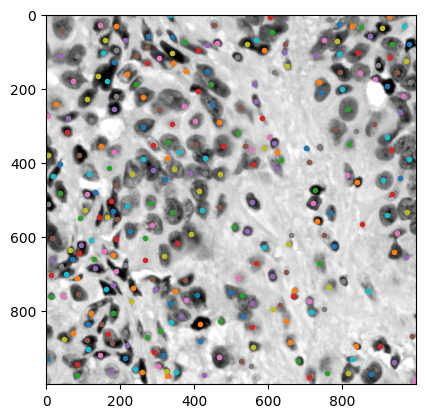

In [ ]:
cropped_im = xenium_im[15000:16000, 5000:6000]

for y,x in markers:
  d = plt.plot(x, y, '.')

plt.imshow(cropped_im)

(-0.5, 999.5, 999.5, -0.5)

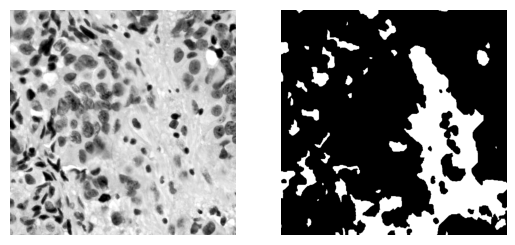

In [ ]:
cropped_im = xenium_im[15000:16000, 5000:6000]
mask = cellcutter.utils.graph_cut(cropped_im, prior = 0.15, max_weight=5, sigma = 0.04)

#check results
fig, ax = plt.subplots(1,2)
ax[0].imshow(cropped_im)
ax[0].axis('off')
ax[1].imshow(mask)
ax[1].axis('off')

In [ ]:
dataset = cellcutter.Dataset(cropped_im, markers, mask_img = mask)

start = time.time()
model = cellcutter.UNet4(bn=True)
cellcutter.train_self_supervised(dataset, model, area_size = 640, lam = 4.0, n_epochs = 60)

print('Elapsed time: %f'%(time.time() - start))

Epoch: 1 (32 steps) -- loss: 3505.655273
Epoch: 2 (64 steps) -- loss: -261.992615
Epoch: 3 (96 steps) -- loss: -751.435974
Epoch: 4 (128 steps) -- loss: -1092.110718
Epoch: 5 (160 steps) -- loss: -1230.744629
Epoch: 6 (192 steps) -- loss: -1125.830688
Epoch: 7 (224 steps) -- loss: -1231.247070
Epoch: 8 (256 steps) -- loss: -1294.646851
Epoch: 9 (288 steps) -- loss: -1250.645752
Epoch: 10 (320 steps) -- loss: -1266.695923
Epoch: 11 (352 steps) -- loss: -1405.332397
Epoch: 12 (384 steps) -- loss: -1397.657715
Epoch: 13 (416 steps) -- loss: -1340.477783
Epoch: 14 (448 steps) -- loss: -1426.313232
Epoch: 15 (480 steps) -- loss: -1472.106079
Epoch: 16 (512 steps) -- loss: -1500.546631
Epoch: 17 (544 steps) -- loss: -1465.485229
Epoch: 18 (576 steps) -- loss: -1529.825928
Epoch: 19 (608 steps) -- loss: -1521.491943
Epoch: 20 (640 steps) -- loss: -1347.836060
Epoch: 21 (672 steps) -- loss: -1346.874634
Epoch: 22 (704 steps) -- loss: -1463.745483
Epoch: 23 (736 steps) -- loss: -1358.385864
Epo

(-0.5, 999.5, 999.5, -0.5)

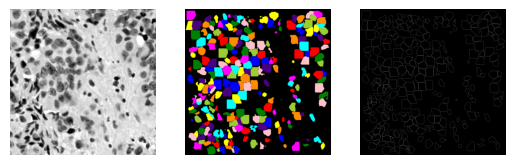

In [ ]:
from skimage.color import label2rgb

label = cellcutter.utils.draw_label(dataset, model, np.zeros_like(cropped_im, dtype=int))
rgb = label2rgb(label, bg_label = 0)
border = cellcutter.utils.draw_border(dataset, model, np.zeros_like(cropped_im, dtype=int))
fig, ax = plt.subplots(1,3)
ax[0].imshow(cropped_im)
ax[0].axis('off')
ax[1].imshow(rgb)
ax[1].axis('off')
ax[2].imshow(border)
ax[2].axis('off')

In [ ]:
dataset2 = cellcutter.Dataset(cropped_im, markers, mask_img = mask)

start = time.time()
model2 = cellcutter.UNet4(bn=True)
cellcutter.train_self_supervised(dataset2, model2, area_size = 640, lam = 4.5, n_epochs = 60)

print('Elapsed time: %f'%(time.time() - start))

Epoch: 1 (32 steps) -- loss: 7366.467773
Epoch: 2 (64 steps) -- loss: 843.736389
Epoch: 3 (96 steps) -- loss: -533.847900
Epoch: 4 (128 steps) -- loss: -705.486572
Epoch: 5 (160 steps) -- loss: -917.373596
Epoch: 6 (192 steps) -- loss: -1035.149292
Epoch: 7 (224 steps) -- loss: -1191.508667
Epoch: 8 (256 steps) -- loss: -1277.082031
Epoch: 9 (288 steps) -- loss: -1278.023560
Epoch: 10 (320 steps) -- loss: -1300.229126
Epoch: 11 (352 steps) -- loss: -1278.996094
Epoch: 12 (384 steps) -- loss: -1318.792236
Epoch: 13 (416 steps) -- loss: -1337.192139
Epoch: 14 (448 steps) -- loss: -1339.761353
Epoch: 15 (480 steps) -- loss: -1120.512695
Epoch: 16 (512 steps) -- loss: -1298.975586
Epoch: 17 (544 steps) -- loss: -1138.132202
Epoch: 18 (576 steps) -- loss: -1308.291992
Epoch: 19 (608 steps) -- loss: -1433.793213
Epoch: 20 (640 steps) -- loss: -1458.544189
Epoch: 21 (672 steps) -- loss: -1482.866577
Epoch: 22 (704 steps) -- loss: -1514.478149
Epoch: 23 (736 steps) -- loss: -1486.453613
Epoch:

(-0.5, 999.5, 999.5, -0.5)

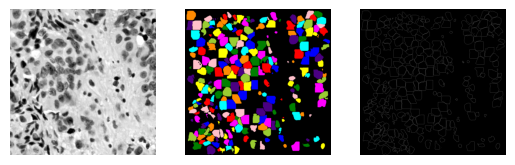

In [ ]:
from skimage.color import label2rgb

label = cellcutter.utils.draw_label(dataset2, model2, np.zeros_like(cropped_im, dtype=int))
rgb = label2rgb(label, bg_label = 0)
border = cellcutter.utils.draw_border(dataset2, model2, np.zeros_like(cropped_im, dtype=int))
fig, ax = plt.subplots(1,3)
ax[0].imshow(cropped_im)
ax[0].axis('off')
ax[1].imshow(rgb)
ax[1].axis('off')
ax[2].imshow(border)
ax[2].axis('off')

In [ ]:
dataset3 = cellcutter.Dataset(cropped_im, markers, mask_img = mask)

start = time.time()
model3 = cellcutter.UNet4(bn=True)
cellcutter.train_self_supervised(dataset3, model3, area_size = 640, lam = 5.0, n_epochs = 60)

print('Elapsed time: %f'%(time.time() - start))

Epoch: 1 (32 steps) -- loss: 6255.850098
Epoch: 2 (64 steps) -- loss: 827.450378
Epoch: 3 (96 steps) -- loss: -549.473267
Epoch: 4 (128 steps) -- loss: -732.942261
Epoch: 5 (160 steps) -- loss: -1101.373779
Epoch: 6 (192 steps) -- loss: -999.032959
Epoch: 7 (224 steps) -- loss: -1100.086304
Epoch: 8 (256 steps) -- loss: -1170.637695
Epoch: 9 (288 steps) -- loss: -1164.515381
Epoch: 10 (320 steps) -- loss: -942.253662
Epoch: 11 (352 steps) -- loss: -1069.788574
Epoch: 12 (384 steps) -- loss: -1195.356689
Epoch: 13 (416 steps) -- loss: -1266.097900
Epoch: 14 (448 steps) -- loss: -1264.027832
Epoch: 15 (480 steps) -- loss: -1245.483398
Epoch: 16 (512 steps) -- loss: -1015.395691
Epoch: 17 (544 steps) -- loss: -850.913208
Epoch: 18 (576 steps) -- loss: -1087.927124
Epoch: 19 (608 steps) -- loss: -1250.117676
Epoch: 20 (640 steps) -- loss: -1271.860840
Epoch: 21 (672 steps) -- loss: -1387.242188
Epoch: 22 (704 steps) -- loss: -1435.798096
Epoch: 23 (736 steps) -- loss: -1402.158325
Epoch: 2

(-0.5, 999.5, 999.5, -0.5)

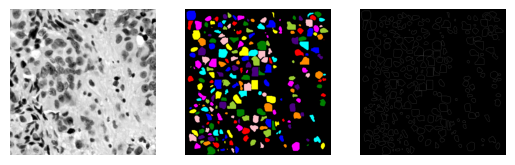

In [ ]:
from skimage.color import label2rgb

label = cellcutter.utils.draw_label(dataset3, model3, np.zeros_like(cropped_im, dtype=int))
rgb = label2rgb(label, bg_label = 0)
border = cellcutter.utils.draw_border(dataset3, model3, np.zeros_like(cropped_im, dtype=int))
fig, ax = plt.subplots(1,3)
ax[0].imshow(cropped_im)
ax[0].axis('off')
ax[1].imshow(rgb)
ax[1].axis('off')
ax[2].imshow(border)
ax[2].axis('off')